In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy as sp

import h5py
import warnings
import random
import math


from matplotlib import rcParams
from matplotlib import cm
from statsmodels.stats.multitest import fdrcorrection
from scipy import stats

warnings.filterwarnings('ignore')
%matplotlib inline

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['savefig.transparent'] = True

In [3]:
adata = sc.read('./matrix_clustered.h5ad')
adata.X = np.expm1(adata.raw.X)

Adapted from github.com/ShawnLYU/Quantile_Normalize/:

In [4]:
def quantileNormalize(df_input):
    df = df_input.copy()
    # Compute Rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    # Sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

### Generate pseudo-bulks for each subset and lineage

In [5]:
n_cells = 1000
n_subs = len(adata.obs['patient'].unique())
patients = adata.obs['patient'].unique()

subset_labels = adata.obs['subclusters'].cat.categories
subcluster_tpm = np.zeros([len(adata.obs['subclusters'].cat.categories)*n_subs,adata.n_vars])

norm_count = [np.mean(adata.obs['n_counts'][adata.obs['subclusters']==x]) for x in subset_labels]
norm_count = norm_count/np.mean(norm_count)

for i, i_subset in enumerate(adata.obs['subclusters'].cat.categories):
    for j in range(n_subs):
        subcluster_matrix = adata[(adata.obs['subclusters']==i_subset) &
                                  (adata.obs['patient']!=patients[j])].X.toarray()
        subcluster_ss_matrix = subcluster_matrix[np.random.randint(len(subcluster_matrix), size=n_cells), :]
        subcluster_bulk_ex = np.sum(subcluster_matrix, axis = 0 )
        subcluster_tpm[i*n_subs+j] = subcluster_bulk_ex/sum(subcluster_bulk_ex)*1e6*norm_count[i]
        
subcluster_tpm_df = pd.DataFrame(subcluster_tpm, columns = adata.var_names)
subcluster_tpm_df = quantileNormalize(subcluster_tpm_df)
subcluster_tpm_df['subcluster'] = np.repeat(subset_labels, n_subs)
subcluster_tpm_df.to_csv('./deconvolution/pseudobulks_subclusters.csv')

In [6]:
subset_labels = adata.obs['lineage'].cat.categories
subcluster_tpm = np.zeros([len(adata.obs['lineage'].cat.categories)*n_subs,adata.n_vars])

norm_count = [np.mean(adata.obs['n_counts'][adata.obs['lineage']==x]) for x in subset_labels]
norm_count = norm_count/np.mean(norm_count)

for i, i_subset in enumerate(adata.obs['lineage'].cat.categories):
    for j in range(n_subs):
        subcluster_matrix = adata[(adata.obs['lineage']==i_subset) &
                                  (adata.obs['patient']!=patients[j])].X.toarray()
        subcluster_ss_matrix = subcluster_matrix[np.random.randint(len(subcluster_matrix), size=n_cells), :]
        subcluster_bulk_ex = np.sum(subcluster_matrix, axis = 0 )
        subcluster_tpm[i*n_subs+j] = subcluster_bulk_ex/sum(subcluster_bulk_ex)*1e6*norm_count[i]
        
subcluster_tpm_df = pd.DataFrame(subcluster_tpm, columns = adata.var_names)
subcluster_tpm_df = quantileNormalize(subcluster_tpm_df)
subcluster_tpm_df['lineage'] = np.repeat(subset_labels, n_subs)
subcluster_tpm_df.to_csv('./deconvolution/pseudobulks_lineage.csv')

### Generate basis matrices

In [7]:
for n_top_genes in np.arange(5,205,5):

    state_markers = []
    lineage_markers = []

    n_var_genes = sum(adata.var['highly_variable'])

    ### Subclusters

    subcluster_tpm_df = pd.read_csv('./deconvolution/pseudobulks_subclusters.csv', index_col=0)
    subcluster_tpm_df = subcluster_tpm_df[adata.var_names[adata.var['highly_variable']].tolist()+['subcluster']]

    subcluster_groups = [['TS1','TS2','TS3'],
                         ['NS1','NS2'],
                         ['BS1','BS2','BS3'],
                         ['MS1','MS2','MS3','MS4','MK'],
                         ['DS1','DS2','DS3']
                        ]

    for i in range(len(subcluster_groups)):
        test_df = subcluster_tpm_df[subcluster_tpm_df['subcluster'].isin(subcluster_groups[i])]
        gene_means = np.empty([len(subcluster_groups[i]), n_var_genes])
        gene_vars = np.std(test_df)

        for j, j_subclust in enumerate(subcluster_groups[i]):
            gene_means[j] = np.mean(test_df[test_df['subcluster']==j_subclust], axis=0)

        for j, j_subclust in enumerate(subcluster_groups[i]):
            gene_diffs = np.empty([len(subcluster_groups[i])-1, n_var_genes])
            a = np.abs(gene_means[j,:] - gene_means[:,:])
            a = a[np.arange(len(a))!=j,:]
            gene_diffs = np.min(a, axis = 0)
            gene_hedges = gene_diffs/gene_vars
            gene_hedges = gene_hedges.dropna()
            ordered_genes = gene_hedges[(-gene_hedges).argsort()].index
            state_markers = list(set(state_markers) | set(ordered_genes[:n_top_genes]))

    ### Lineage

    subcluster_tpm_df = pd.read_csv('./deconvolution/pseudobulks_lineage.csv', index_col=0)
    subcluster_tpm_df = subcluster_tpm_df[adata.var_names[adata.var['highly_variable']].tolist()+['lineage']]

    subset_labels = adata.obs['lineage'].cat.categories

    gene_means = np.empty([len(subset_labels), n_var_genes])
    gene_vars = np.std(subcluster_tpm_df)

    for j, j_subclust in enumerate(subset_labels):
        gene_means[j] = np.mean(subcluster_tpm_df[subcluster_tpm_df['lineage']==j_subclust], 
                                axis=0)

    for j, j_subclust in enumerate(subset_labels):
        gene_diffs = np.empty([len(subset_labels)-1, n_var_genes])
        a = np.abs(gene_means[j,:] - gene_means[:,:])
        a = a[np.arange(len(a))!=j,:]
        gene_diffs = np.min(a, axis = 0)
        gene_hedges = gene_diffs/gene_vars
        gene_hedges = gene_hedges.dropna()
        ordered_genes = gene_hedges[(-gene_hedges).argsort()].index
        lineage_markers = list(set(lineage_markers) | set(ordered_genes[:n_top_genes]))

    markers = list(set(state_markers + lineage_markers))
    len(state_markers),len(lineage_markers),len(markers)
    
    ### Get markers
    
    subset_labels = adata.obs['subclusters'].cat.categories
    subcluster_tpm_df = pd.read_csv('./deconvolution/pseudobulks_subclusters.csv', index_col=0)
    gene_means = np.empty([len(subset_labels), len(subcluster_tpm_df.columns)-1])

    for i, i_subclust in enumerate(subset_labels):
        gene_means[i] = np.mean(subcluster_tpm_df[subcluster_tpm_df['subcluster']==i_subclust].iloc[:,:-1], axis=0)

    basis_df = pd.DataFrame(gene_means)
    basis_df['subcluster'] = subset_labels
    basis_df.columns = subcluster_tpm_df.columns

    basis_means = basis_df[markers].round(2)

    basis_matrix_df = basis_means.transpose()
    basis_matrix_df.columns = subset_labels
    basis_matrix_df.to_csv('./deconvolution/basis/septiStates_'+str(n_top_genes)+'.txt', sep='\t', index_label=True)


### Generate pseudobulks for each patient for deconvolution accuracy testing

In [8]:
n_subs = len(adata.obs['patient'].unique())
patients = adata.obs['patient'].unique()

subcluster_tpm = np.zeros([n_subs,adata.n_vars])

for i in range(n_subs):
    subcluster_matrix = adata[adata.obs['patient'] == patients[i]].X.toarray()
    subcluster_bulk_ex = np.sum(subcluster_matrix, axis = 0)
    subcluster_tpm[i] = subcluster_bulk_ex/sum(subcluster_bulk_ex)*1e6
        
subcluster_tpm_df = pd.DataFrame(subcluster_tpm, columns = adata.var_names)
subcluster_tpm_df = quantileNormalize(subcluster_tpm_df)
subcluster_tpm_df.index = patients

subcluster_tpm_df.transpose().to_csv('./deconvolution/test_data_patients.txt', sep='\t', index_label=True)

### Deconvolve test data

Run deconvolution on test_data_patients.txt using CIBERSORT for each basis matrix

Source code for CIBERSORT can be downloaded from https://cibersort.stanford.edu/index.php.

### Evaluate matrix performance

In [9]:
anno_subsets = 'subclusters'
anno_pointdef = 'patient'

## Get number of categories
subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
n_subsets = len(subset_ids)
patient_ids = adata.obs[anno_pointdef].unique()
n_patients = len(patient_ids)

## Calculate subset fractions
subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                index = patient_ids ,
                                columns = subset_ids)
for i in np.arange(n_patients):
    ind2 = adata.obs[anno_pointdef] == patient_ids[i]
    for j in np.arange(n_subsets):
        ind1 = adata.obs[anno_subsets] == subset_ids[j]
        subset_frac.iloc[i,j] = sum(ind1&ind2)
subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

subcluster_tpm_df = pd.read_csv('./deconvolution/test_data_patients.txt', sep='\t', index_col=0).transpose()

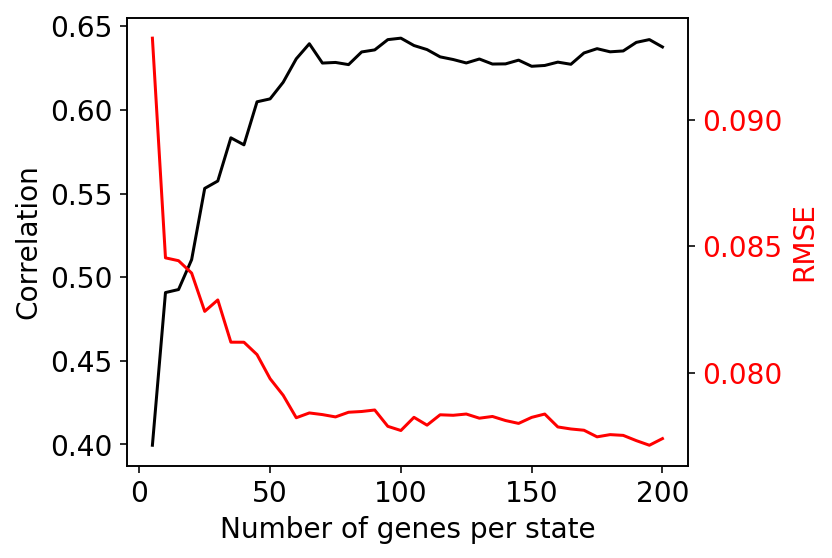

In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt

subset_labels = adata.obs['subclusters'].cat.categories

n_gene_range = np.arange(5,205,5)

subset_corrs = np.zeros([len(subset_frac.index),len(n_gene_range)])
subset_rmse = np.zeros([len(subset_frac.index),len(n_gene_range)])

for i, i_n_top_genes in enumerate (n_gene_range):
    test_results_df = pd.read_csv('./deconvolution/basis/optMatrixDecon_'+str(i_n_top_genes) +'.txt', 
                                  sep='\t', index_col=0)
    for j, j_patient in enumerate(subset_frac.index):
        subset_corrs[j,i], _ = sp.stats.pearsonr(test_results_df.loc[j_patient,subset_frac.columns],
                                               subset_frac.loc[j_patient])
        subset_rmse[j,i] = sqrt(mean_squared_error(test_results_df.loc[j_patient,subset_frac.columns],
                                                 subset_frac.loc[j_patient]))

fig, ax1 = plt.subplots(figsize=(6,4))

ax1.plot(n_gene_range, np.mean(subset_corrs, axis=0), 'k')
plt.grid(None)
plt.ylabel('Correlation')
plt.xlabel('Number of genes per state')

ax2 = ax1.twinx()
ax2.plot(n_gene_range, np.mean(subset_rmse, axis=0), 'r')
plt.grid(None)
plt.ylabel('RMSE', color='red')
plt.yticks(color='red')

plt.xticks(np.arange(0,205,50))
plt.tight_layout()

### Select matrix and visualize

<Figure size 288x288 with 0 Axes>

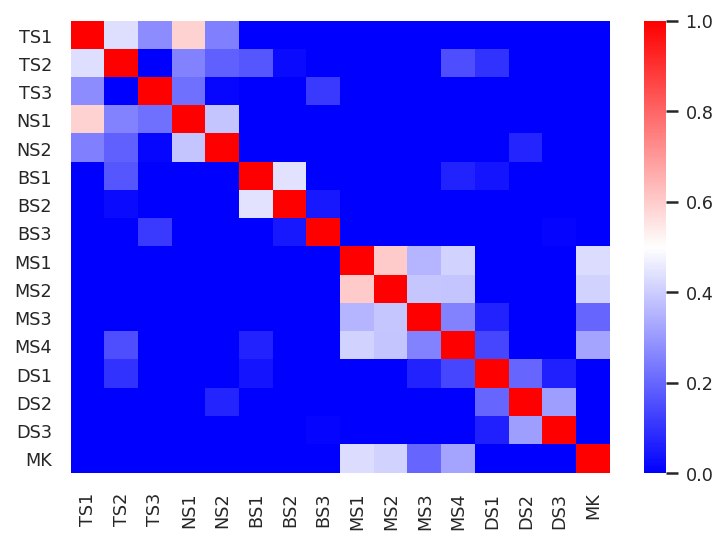

In [11]:
basis_means = pd.read_csv('./deconvolution/basis/septiStates_150.txt', index_col=0, sep='\t').transpose()

subset_labels = adata.obs['subclusters'].cat.categories
basis_norm = np.log1p(basis_means)
basis_norm = sp.stats.zscore(basis_norm, axis=1)
basis_norm_df = pd.DataFrame(basis_norm.transpose(), columns= subset_labels)

basis_norm_df = basis_norm_df[['TS1','TS2','TS3',
                              'NS1','NS2','BS1','BS2','BS3',
                              'MS1','MS2','MS3','MS4',
                              'DS1','DS2','DS3','MK'
                             ]]
plt.figure(figsize=(4,4))
corr = basis_norm_df.corr()
sns.set(font_scale=0.8)
plt.figure(figsize=(6,4))
sns.heatmap(corr, cmap='bwr', vmin=0, vmax=1)

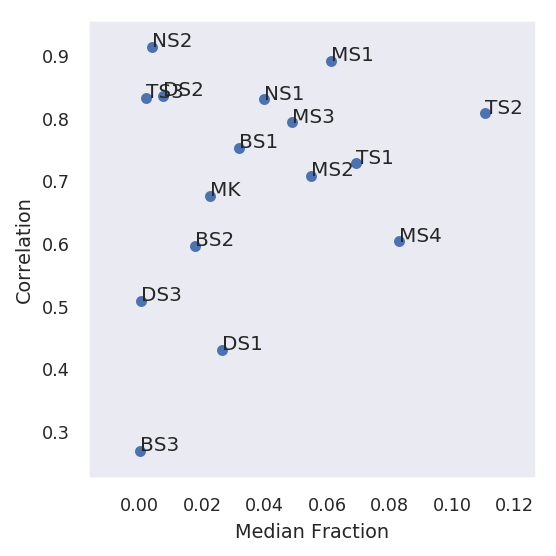

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

test_results_df = pd.read_csv('./deconvolution/basis/optMatrixDecon_150.txt', 
                              sep='\t', index_col=0)

diffs = subset_frac - test_results_df.iloc[:,:-3]

rmse = np.empty([16])
for i, i_subset in enumerate(subset_ids):
    rmse[i], _ = sp.stats.pearsonr(subset_frac[i_subset], test_results_df[i_subset])
    
mean_fracs = np.median(subset_frac, axis = 0)

plt.figure(figsize=(4,4))
plt.scatter(mean_fracs,rmse, s=20)
for i, i_subset in enumerate(subset_ids):
    plt.text(x=mean_fracs[i],y=rmse[i], s = i_subset, fontsize=10)
plt.xlabel('Median Fraction')
plt.ylabel('Correlation')
plt.grid(False)
plt.tight_layout()